<a href="https://colab.research.google.com/github/beeyan/Analytics/blob/master/causal_inference_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 因果推論周りの勉強のためのnotebook

岩波booksのサンプルデータを用いて, 因果推論の一連の流れを学ぶ

参考url: https://pira-nino.hatenablog.com/entry/causal_inference_implement

In [0]:
!pip install lightgbm

In [0]:
import lightgbm as lgb
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.neighbors import NearestNeighbors


%matplotlib inline
# その他設定
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-darkgrid')
font = fm.FontProperties(fname='./TakaoPGothic.ttf')

dataset_url = 'https://raw.githubusercontent.com/' \
              + 'iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv'  
df = pd.read_csv(dataset_url)  
print(df.shape)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


(10000, 35)


In [0]:
# 列名のチェック. 項目に対して, ダミー編数化の処理がなされている
df.columns

Index(['cm_dummy', 'gamedummy', 'area_kanto', 'area_keihan', 'area_tokai',
       'area_keihanshin', 'age', 'sex', 'marry_dummy', 'job_dummy1',
       'job_dummy2', 'job_dummy3', 'job_dummy4', 'job_dummy5', 'job_dummy6',
       'job_dummy7', 'job_dummy8', 'inc', 'pmoney', 'fam_str_dummy1',
       'fam_str_dummy2', 'fam_str_dummy3', 'fam_str_dummy4', 'fam_str_dummy5',
       'child_dummy', 'T', 'F1', 'F2', 'F3', 'M1', 'M2', 'M3', 'TVwatch_day',
       'gamesecond', 'gamecount'],
      dtype='object')

In [0]:
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,job_dummy2,job_dummy3,job_dummy4,job_dummy5,job_dummy6,job_dummy7,job_dummy8,inc,pmoney,fam_str_dummy1,fam_str_dummy2,fam_str_dummy3,fam_str_dummy4,fam_str_dummy5,child_dummy,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,0,0,0,0,0,0,0,249.5,0.0,0,0,1,0,0,1,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,800.0,12.5,0,0,1,0,0,1,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,0,0,0,0,0,1,0,0.0,2.0,0,0,0,1,0,0,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,0,0,0,0,0,0,0,800.0,2.0,0,0,1,0,0,1,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,0,0,0,0,0,0,0,749.5,4.0,0,0,1,0,0,1,0,0,0,0,1,0,0,49.344942,0,0


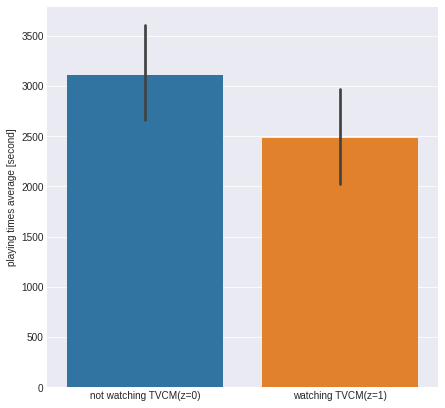

In [0]:
# 単純な集計を行うと, cmを見ていない人の方が, cmを見ている人よりもプレイ時間が長くなる.
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1)
ax = sns.barplot(x='cm_dummy', y='gamesecond', data=df, ax=ax)
ax.set_xticklabels(['not watching TVCM(z=0)', 'watching TVCM(z=1)'])
ax.set_xlabel('')
ax.set_ylabel('playing times average [second]')
fig.show();

# matplotlibのRuntimeWarningがやかましいので消す
import warnings
warnings.simplefilter('ignore', RuntimeWarning)

In [0]:
z_col = 'cm_dummy'
x_cols = [
          col for col in df.columns
          if col not in ['gemecount', 'gamedummy', 'gamesecond', 'cm_dummy']
]

df_x = df[x_cols]
df_z = df[z_col]

In [0]:
# logistic regression/random forest/light gbmの実装を行う

#初期化
test_ratio = 0.2
oof_preds_lgb = np.zeros(df.shape[0])
oof_preds_lr = np.zeros(df.shape[0])
oof_preds_rf = np.zeros(df.shape[0])

insample_logloss_list_lgb = []
insample_logloss_list_lr = []
insample_loglooss_list_rf = []
feature_importance_df = pd.DataFrame()

# Kfoldで分割
kf = KFold(n_splits=5, shuffle=True, random_state=0)

for n_fold, (train_index, valid_index) in enumerate(kf.split(df_x)):
  print('CV_{}'.format(n_fold))
  X_train, z_train = df_x.values[train_index], df_z.values[train_index]
  X_test, z_test = df_x.values[train_index], df_z.values[train_index]

  #train => TRAIN / VALに分割する
  num_test = int(len(X_train)*test_ratio)
  index_all = np.random.choice(len(X_train), len(X_train), replace=False)
  index_VAL = index_all[0:num_test]
  index_TRAIN = index_all[num_test:len(X_train)]

  X_TRAIN, z_TRAIN = X_train[index_TRAIN], z_train[index_TRAIN]
  X_VAL, z_VAL = X_train[index_VAL], z_train[index_VAL]

  lgb_train = lgb.Dataset(X_TRAIN, label=z_TRAIN, free_raw_data=False)
  lgb_val = lgb.Dataset(X_VAL, label=z_VAL, free_raw_data=False)

  # LightGBM
  print('LightGBM is fitting.....')
  params = {
      'task': 'train',
      'objective': 'binary',
      'metric': 'binary'
  }

  model_lgb = lgb.train(
      params,
      lgb_train,
      valid_sets = [lgb_train, lgb_val],
      valid_names = ['train', 'val'],
      num_boost_round=100000,
      early_stopping_rounds=100,
      verbose_eval=1000)
  
  # Logistic Regression
  print('Logistic Regression is fitting.....')
  model_lr = LogisticRegression()
  model_lr.fit(X_train, z_train)

  # Random Forest
  print('Random Forest is fitting......')
  model_rf = RandomForestClassifier(n_estimators=500)
  model_rf.fit(X_train, z_train)

  # モデルを用いて予測値を算出する
  

  



CV_0
CV_1
CV_2
CV_3
CV_4
